In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
import tensorflow as tf
import transformers
from transformers import TFBertForTokenClassification
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import ABSATokenizer, convert_examples_to_tf_dataset, read_conll
import utils.utils as utils
import utils.pos_utils as pos_utils
import utils.postprocessing_utils as post_utils

#<img src="attachment:image.png" width="300" height="300" align="left">
"""
<hr>
<a id=""></a>

[Back to contents](#index)
""";

<a id="index"></a>

[A.1. Average length vs Mean Accuracy over Language](#A1)

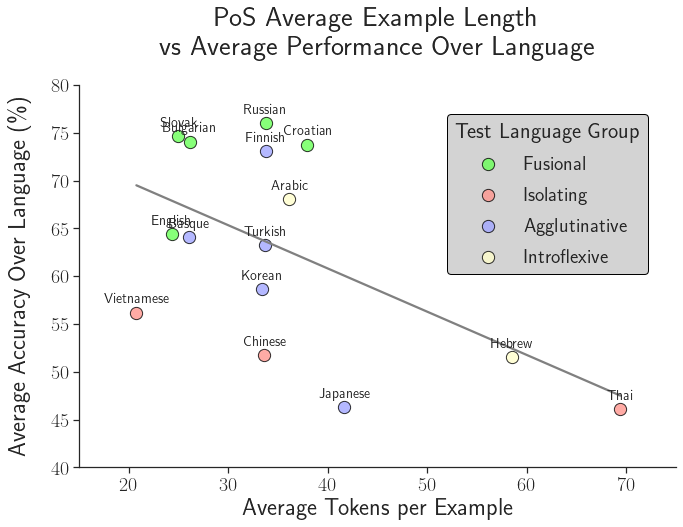

<hr>
<a id="A1"></a>

[Back to contents](#index)

### A.1. Average length vs Mean Accuracy over Language

In [15]:
results = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
df = results["Accuracy"]["langvlang"].iloc[:15]
df = df.rename(columns={"Test\Train": "Test Language"}).drop("Thai", axis=1)

In [16]:
lang_cols = df.columns[2:-1]
means = []
for i, row in df.iterrows():
    row_mean = row[[col for col in lang_cols if col != row["Test Language"]]].mean()
    means.append(row_mean)
df["Mean-Accuracy-Over"] = np.array(means) * 100

In [17]:
df = pd.DataFrame({"Test-Group": df["Group"], "Test-Language": df["Test Language"], 
                   "Mean-Accuracy-Over": df["Mean-Accuracy-Over"]})
df = pd.merge(df, basic_stats[["language", "train_examples", "test_avg_tokens"]], how="left", 
              left_on="Test-Language", right_on="language")

In [18]:
pearsonr(x=df["test_avg_tokens"], y=df["Mean-Accuracy-Over"])

(-0.5568057659298696, 0.03108446045637787)

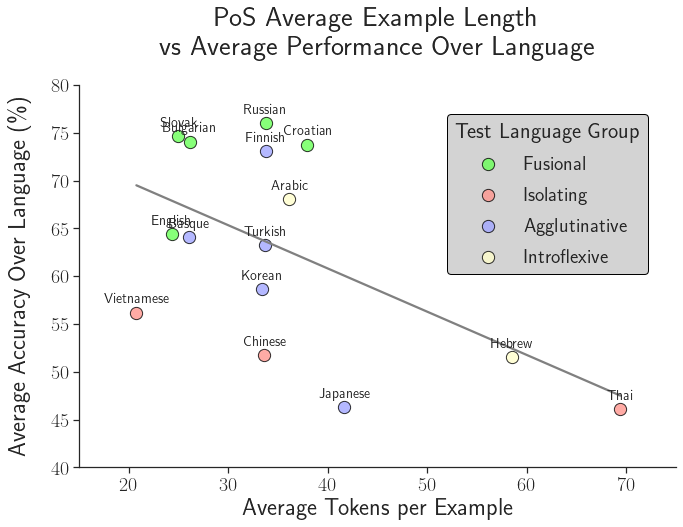

In [20]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="test_avg_tokens", y="Mean-Accuracy-Over", data=df, hue="Test-Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="test_avg_tokens", y="Mean-Accuracy-Over", data=df, 
            scatter=False, color="grey", ci=None, order=1)

for i, row in df.iterrows():
    plt.text(row["test_avg_tokens"], row["Mean-Accuracy-Over"] + 1, row["Test-Language"], fontsize=14, 
             horizontalalignment="center")

plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.6, 0.95), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((40,80))
plt.xlim((15,75))
plt.ylabel("Average Accuracy Over Language (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Average Tokens per Example", fontsize=24 +  extra_fontsize)
plt.title("PoS Average Example Length \n vs Average Performance Over Language", fontsize=28 +  extra_fontsize, pad=30)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/pos_length_vs_accuracy_over_lang.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()